# Working with RasterIO

[RasterIO](https://rasterio.readthedocs.io/en/latest/) is a modern library to work with geospatial data in a gridded format. It excels at providing an easy way to read/write raster data and access individual bands and pixels as `numpy` arrays.

RasterIO is built on top of the popular [GDAL (Geospatial Data Abstraction Library)](https://gdal.org/). GDAL is written in C++ so the Python API provided by GDAL is not very intuitive for Python users. RaserIO aims to make it easy for Python users to use the underlying GDAL library in an intuitive way.

In this section, we will take 4 individual SRTM tiles around the Mt. Everest region and merge them to a single GeoTiff using RasterIO.

![](images/python_foundation/srtm.png)

In [3]:
import rasterio

In [56]:
import os
data_pkg_path = 'data'
srtm_dir = 'srtm'
filename = 'N28E087.hgt'
path = os.path.join(data_pkg_path, srtm_dir, filename)

## Reading Raster Data

RasterIO can read any raster format supported by the GDAL library. We can call the `open()` method with the file path of the raster. The resulting dataset behaves much like Python's File object.

In [57]:
dataset = rasterio.open(path)

You can check information about the raster using the `meta` attribute.

An important property is the dataset *transform*. The transform contains the pixel resolution of the dataset and the row and column coordinates of the upper left corner of the dataset.

In [58]:
metadata = dataset.meta
metadata

{'driver': 'SRTMHGT',
 'dtype': 'int16',
 'nodata': -32768.0,
 'width': 3601,
 'height': 3601,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.0002777777777777778, 0.0, 86.99986111111112,
        0.0, -0.0002777777777777778, 29.000138888888888)}

In [65]:
trans = dataset.meta['transform']
print(trans.__class__)
print(trans)
print()

lon, lat = trans * (1,2)
print((lon,lat))

<class 'affine.Affine'>
| 0.00, 0.00, 87.00|
| 0.00,-0.00, 29.00|
| 0.00, 0.00, 1.00|

(87.0001388888889, 28.999583333333334)


To read the pixel values, we need to call the `read()` method by passing it a band’s index number. Following the GDAL convention, bands are indexed from 1. Since our dataset contain just 1-band (`count` tells us this), we can read it as follows.

In [36]:
band1 = dataset.read(1)
print(band1.__class__)
print(band1.shape)
print()
print(band1)

<class 'numpy.ndarray'>
(3601, 3601)

[[5217 5211 5208 ... 5097 5098 5089]
 [5206 5201 5200 ... 5080 5075 5069]
 [5199 5194 5191 ... 5063 5055 5048]
 ...
 [5347 5345 5343 ... 5747 5750 5757]
 [5338 5338 5336 ... 5737 5740 5747]
 [5332 5331 5332 ... 5734 5736 5744]]


To get metadata tags specific to a raster band we can call `.tags()` method. *Note* There is no standard for what information will be contained in each band.

In [26]:
band1_tags = dataset.tags(0)
print(band1_tags)

{'AREA_OR_POINT': 'Point'}


Finally, when we are done with the dataset, we must close it. It is especially important when writing a dataset.

In [67]:
dataset.close()

# Try Plotting

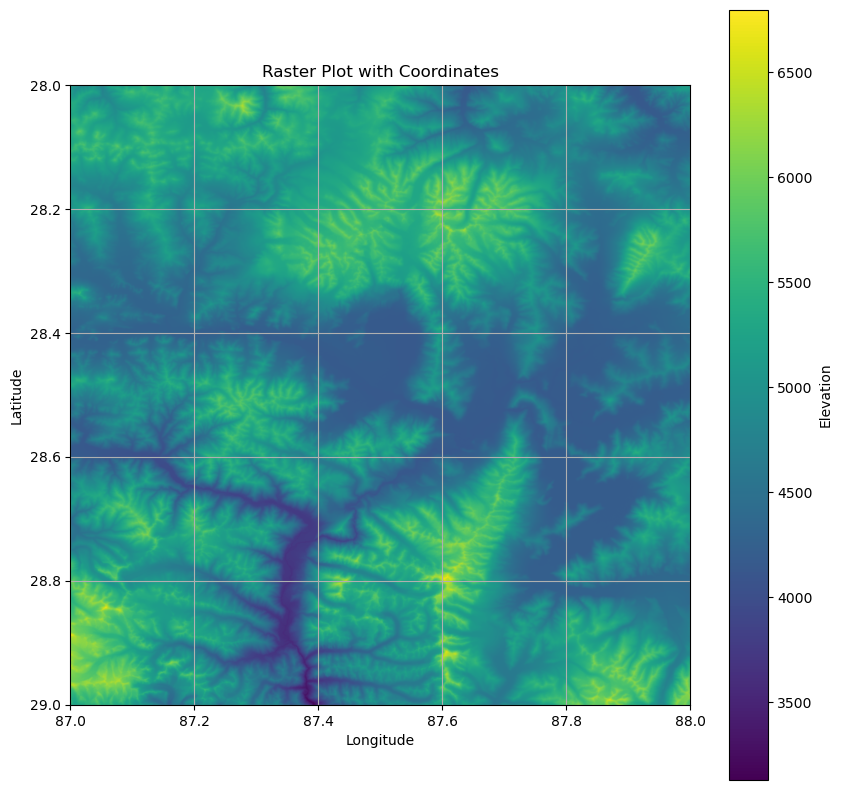

In [66]:
import matplotlib.pyplot as plt

# bands = dataset.read() # reads all bands into single numpy ndarray (multi-dimensions)
# plt.imshow(bands)
# plt.imshow(band1) # plot band 1
# plt.show()

# Specify the path to your raster file (e.g., GeoTIFF)
# path = path

# Open the raster file using Rasterio
with rasterio.open(path) as src:
    # Read the raster data as a NumPy array
    raster_data = src.read(1)  # Use the band index (1-based) you want to visualize

    # Get the affine transformation matrix (geotransform)
    transform = src.transform

    # Get the extent of the raster in geographic coordinates
    xmin, ymin = transform * (0, 0)  # Top-left corner
    xmax, ymax = transform * (src.width, src.height)  # Bottom-right corner

# Plot the raster
plt.figure(figsize=(10, 10))
plt.imshow(raster_data, extent=(xmin, xmax, ymin, ymax), cmap='viridis')  # Adjust the colormap as needed
plt.colorbar(label='Elevation')  # Add colorbar with a label
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Raster Plot with Coordinates')
plt.grid(True)
plt.show()


## Merging Datasets

Let's see how we can read the 4 individual tiles and mosaic them together. RasterIO provides multiple sub-modules for various raster operations. We can use the `rasterio.merge` module to carry out this operation.

We first find all the individual files in the directory using the `os.listdir()` function.

In [38]:
srtm_path = os.path.join(data_pkg_path, 'srtm')
all_files = os.listdir(srtm_path)
print(all_files)

['N27E086.hgt', 'N27E087.hgt', 'N28E086.hgt', 'N28E087.hgt']


The rasterio.merge module has a `merge()` method that takes a list of *datasets* and returns the merged dataset. So we create an empty list, open each of the files and append it to the list.

In [39]:
dataset_list = []
for file in all_files:
    path = os.path.join(srtm_path, file)
    dataset_list.append(rasterio.open(path))
print(dataset_list)

[<open DatasetReader name='data\srtm\N27E086.hgt' mode='r'>, <open DatasetReader name='data\srtm\N27E087.hgt' mode='r'>, <open DatasetReader name='data\srtm\N28E086.hgt' mode='r'>, <open DatasetReader name='data\srtm\N28E087.hgt' mode='r'>]


We can pass on the list of tile dataset to the merge method, which will return us the merged data and a new *transform* which contains the updated extent of the merged raster.

In [40]:
from rasterio import merge
merged_result = merge.merge(dataset_list)
print(merged_result)

(array([[[4916, 4926, 4931, ..., 5097, 5098, 5089],
        [4919, 4932, 4928, ..., 5080, 5075, 5069],
        [4919, 4928, 4935, ..., 5063, 5055, 5048],
        ...,
        [ 368,  368,  366, ..., 1905, 1919, 1937],
        [ 364,  364,  362, ..., 1913, 1930, 1944],
        [ 360,  359,  357, ..., 1918, 1930, 1942]]], dtype=int16), Affine(0.0002777777777777778, 0.0, 85.99986111111112,
       0.0, -0.0002777777777777778, 29.000138888888888))


We save the data and the transform to separate variables.

In [73]:
merged_data = merged_result[0]      # Numpy array of cell values
merged_shape = merged_data.shape    # (layer_index, latitude, longitude)
merged_transform = merged_result[1] # Affine transformation


Verify that the resulting array shape the sum of individual rasters

In [75]:
print(merged_data.__class__)
print()
print(merged_shape)
print()
print(merged_data)

<class 'numpy.ndarray'>

(1, 7201, 7201)

[[[4916 4926 4931 ... 5097 5098 5089]
  [4919 4932 4928 ... 5080 5075 5069]
  [4919 4928 4935 ... 5063 5055 5048]
  ...
  [ 368  368  366 ... 1905 1919 1937]
  [ 364  364  362 ... 1913 1930 1944]
  [ 360  359  357 ... 1918 1930 1942]]]


# Plot

*Note* The merge operation creates a 3d array, where the dimensions are [layer, latitude, longitude], so select the layer you want to plot with `stack[<layer_index_number>]`

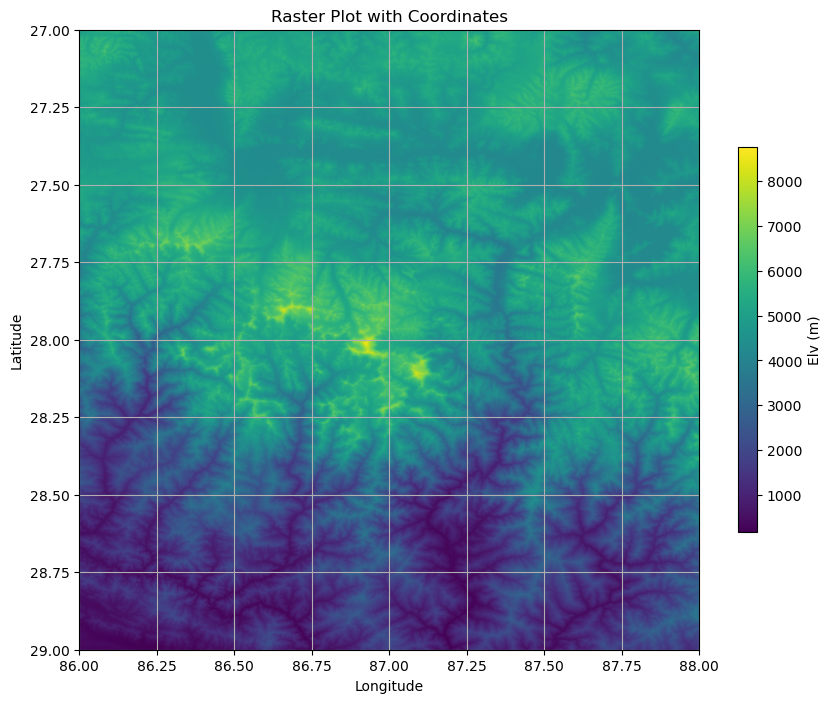

In [93]:
# Get the extent of the raster in geographic coordinates
xmin, ymin = merged_transform * (0, 0)  # Top-left corner
xmax, ymax = merged_transform * (merged_shape[2], merged_shape[1])  # Bottom-right corner

# Plot the raster
plt.figure(figsize=(10, 10))
plt.imshow(merged_data[0], extent=(xmin, xmax, ymin, ymax), cmap='viridis')  # Adjust the colormap as needed
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Raster Plot with Coordinates')
cbar = plt.colorbar(label='Elv (m)', shrink=0.5)  # Add colorbar with a label
# cbar.ax.xaxis.set_label_position('top')
# cbar.ax.xaxis.set_ticks_position('top')
# cbar.ax.set_xlabel('Elv (m)', labelpad=10)
plt.grid(True)
plt.show()



## Writing Raster Data

Similar to regular Python files, to create a new file, we can open the output file in the *write* mode. RasterIO provides a `write()` method that we can use to write individual bands.

In [54]:
output_filename = 'merged.tif'
output_dir = 'output'
output_path = os.path.join(output_dir, output_filename)

We need to specify many metadata parameters to initialize the output dataset. Some of these parameter values can be directly copied from the input files, such as `crs`, `dtype`, `nodata` etc. , while others can be obtained from the merged dataset, such as `height` and `width`.

Remember to call the `close()` method which will finalize the file and write the data to disk.

In [55]:
new_dataset = rasterio.open(output_path, 'w', 
                            driver='GTiff',
                            height=merged_data.shape[1],
                            width=merged_data.shape[2],
                            count=1,
                            nodata=-32768.0,
                            dtype=merged_data.dtype,
                            crs='EPSG:4326',
                            transform=merged_transform)
new_dataset.write(merged_data)
new_dataset.close()
print('Successfully written output file at {}'.format(output_path))

Successfully written output file at output\merged.tif


## Exercise

The merged array represents elevation values. The extent of the tiles cover Mt. Everest. Read the resulting raster and find the maximum elevation value contained in it.

In [99]:
import rasterio
import os
import numpy as np

output_filename = 'merged.tif'
output_dir = 'output'
output_path = os.path.join(output_dir, output_filename)

# Read the output file as a NumPy array and find the maximum value
with rasterio.open(output_path) as src:
    dat = src.read(1)
    print(dat)
    print()
    print('Max Elevation: {} meters'.format(np.max(dat)))

[[4916 4926 4931 ... 5097 5098 5089]
 [4919 4932 4928 ... 5080 5075 5069]
 [4919 4928 4935 ... 5063 5055 5048]
 ...
 [ 368  368  366 ... 1905 1919 1937]
 [ 364  364  362 ... 1913 1930 1944]
 [ 360  359  357 ... 1918 1930 1942]]

Max Elevation: 8748 meters


----